In [1]:
"""
Bivariate Relationship Exploration

This notebook explores complex relationships between metabolic variables:
1. LOESS smoothing to identify non-linear patterns
2. Stratified scatterplots to reveal conditional relationships
3. Interaction effects analysis
4. Threshold effect detection
5. Relationship strength across clinical categories

"""

import sys
sys.path.append('../../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Pastel colors
pastel_colors = ['#FFB6C1', '#B0E0E6', '#DDA0DD', '#F0E68C', '#98FB98', 
                 '#FFE4B5', '#E6E6FA', '#FFC0CB']
sns.set_palette(pastel_colors)

print("BIVARIATE RELATIONSHIP EXPLORATION - PHASE 2, STEP 4")
print("Going beyond correlations to understand complex relationships\n")

BIVARIATE RELATIONSHIP EXPLORATION - PHASE 2, STEP 4
Going beyond correlations to understand complex relationships



In [2]:
# Load data
df = pd.read_csv("../../data/processed/nhanes_metabolic_with_mets.csv")

print(f"Loaded data: {df.shape[0]:,} participants × {df.shape[1]} variables")

# Core variables
core_vars = ['LBXGLU', 'LBXTLG', 'BMXWAIST']
var_labels = {
    'LBXGLU': 'Fasting Glucose (mg/dL)',
    'LBXTLG': 'Triglycerides (mg/dL)',
    'BMXWAIST': 'Waist Circumference (cm)'
}

# Remove missing values for bivariate analysis
df_complete = df[core_vars].dropna()
print(f"\nComplete cases for bivariate analysis: {len(df_complete):,}")

# Basic correlations (Pearson)
print("\nPearson Correlations:")
corr_matrix = df_complete.corr()
print(corr_matrix.round(3))

print("\nData loaded and ready for bivariate exploration")

Loaded data: 3,047 participants × 50 variables

Complete cases for bivariate analysis: 3,047

Pearson Correlations:
          LBXGLU  LBXTLG  BMXWAIST
LBXGLU     1.000   0.315     0.233
LBXTLG     0.315   1.000     0.218
BMXWAIST   0.233   0.218     1.000

Data loaded and ready for bivariate exploration


Saved: ../../results/figures/loess_glucose_triglycerides.png


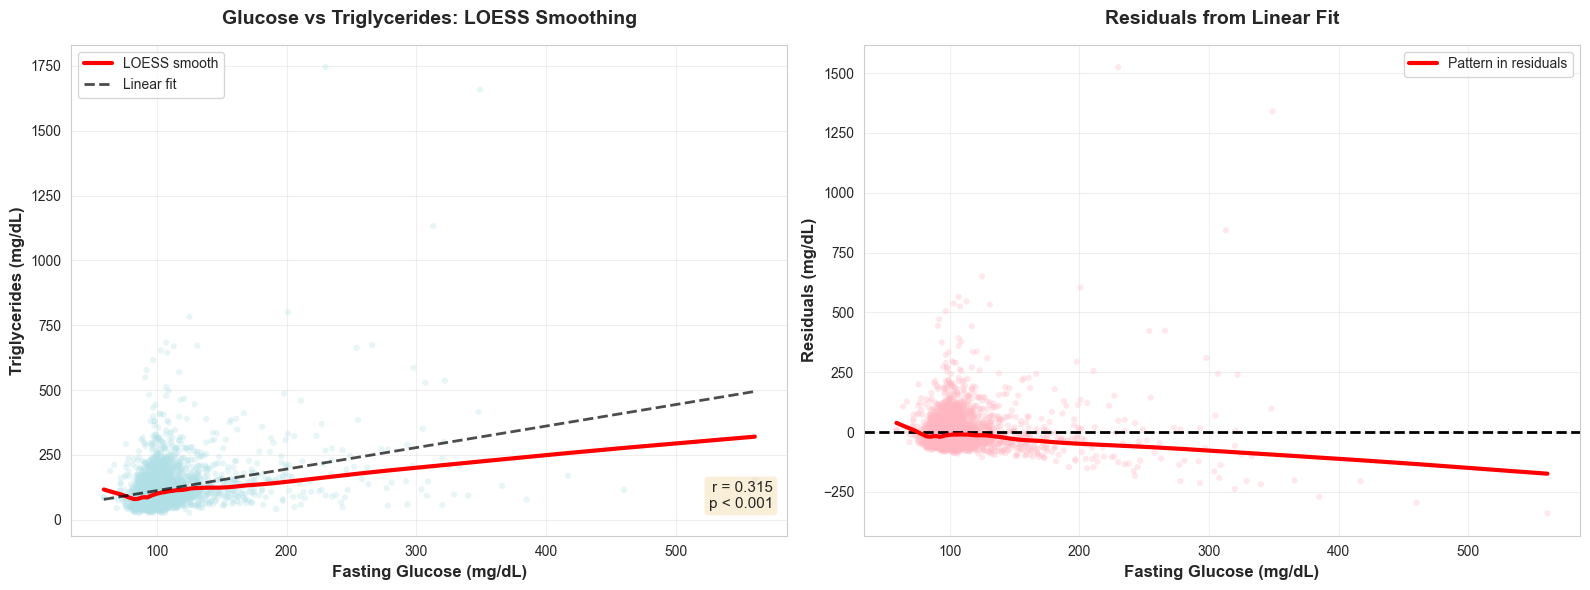


Interpretation:
  → Non-linear pattern detected: LOESS curve deviates from linear fit
  → Relationship may be stronger/weaker at different glucose levels


In [3]:
# LOESS smoothing for Glucose vs Triglycerides
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/loess_glucose_triglycerides.png'
    else:
        save_path = '../results/figures/loess_glucose_triglycerides.png'
else:
    save_path = 'results/figures/loess_glucose_triglycerides.png'

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data
x = df_complete['LBXGLU'].values
y = df_complete['LBXTLG'].values

# Sort for plotting
sort_idx = np.argsort(x)
x_sorted = x[sort_idx]
y_sorted = y[sort_idx]

# Left plot: Scatterplot with LOESS
ax1 = axes[0]
ax1.scatter(x, y, alpha=0.3, s=20, color='#B0E0E6', edgecolors='none')

# Fit LOESS curve
smoothed = lowess(y, x, frac=0.2)
ax1.plot(smoothed[:, 0], smoothed[:, 1], 'r-', linewidth=3, label='LOESS smooth')

# Linear regression for comparison
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax1.plot(x_sorted, p(x_sorted), 'k--', linewidth=2, label='Linear fit', alpha=0.7)

ax1.set_xlabel('Fasting Glucose (mg/dL)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Triglycerides (mg/dL)', fontsize=12, fontweight='bold')
ax1.set_title('Glucose vs Triglycerides: LOESS Smoothing', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3)

# Add correlation
r, p_val = stats.pearsonr(x, y)
ax1.text(0.98, 0.05, f'r = {r:.3f}\np < 0.001', 
         transform=ax1.transAxes, ha='right', va='bottom',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=11)

# Right plot: Residuals from linear fit
ax2 = axes[1]
residuals = y - p(x)
ax2.scatter(x, residuals, alpha=0.3, s=20, color='#FFB6C1', edgecolors='none')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=2)

# Smooth residuals to show non-linearity
smoothed_resid = lowess(residuals, x, frac=0.2)
ax2.plot(smoothed_resid[:, 0], smoothed_resid[:, 1], 'r-', linewidth=3, label='Pattern in residuals')

ax2.set_xlabel('Fasting Glucose (mg/dL)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Residuals (mg/dL)', fontsize=12, fontweight='bold')
ax2.set_title('Residuals from Linear Fit', fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

# Interpretation
print("\nInterpretation:")
if np.abs(smoothed_resid[:, 1]).max() > 20:
    print("  → Non-linear pattern detected: LOESS curve deviates from linear fit")
    print("  → Relationship may be stronger/weaker at different glucose levels")
else:
    print("  → Relationship appears approximately linear")

Saved: ../../results/figures/loess_all_pairs.png


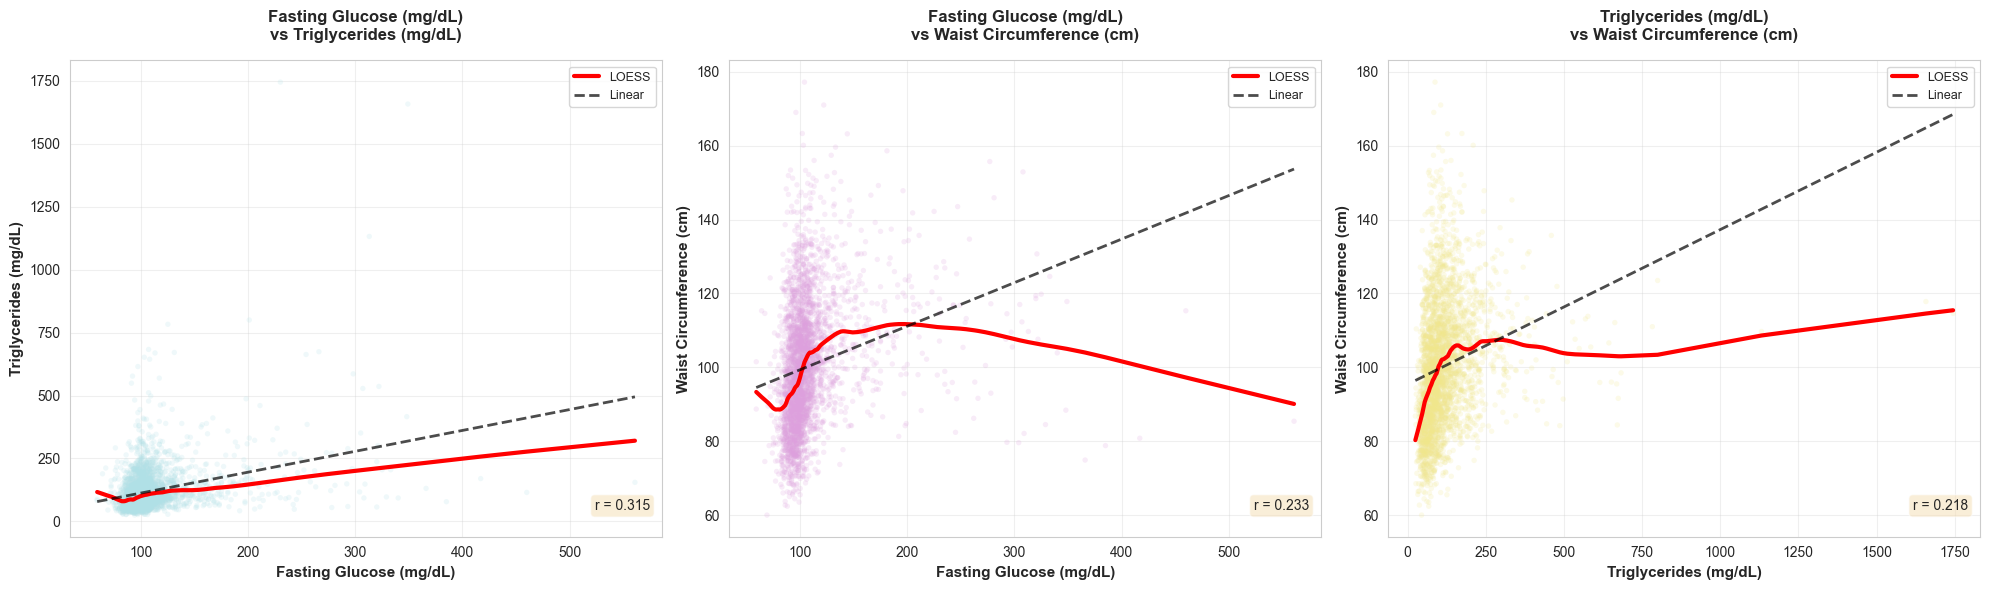

In [4]:
# Create LOESS plots for all three variable pairs
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/loess_all_pairs.png'
    else:
        save_path = '../results/figures/loess_all_pairs.png'
else:
    save_path = 'results/figures/loess_all_pairs.png'

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

pairs = [
    ('LBXGLU', 'LBXTLG', '#B0E0E6'),
    ('LBXGLU', 'BMXWAIST', '#DDA0DD'),
    ('LBXTLG', 'BMXWAIST', '#F0E68C')
]

for idx, (var1, var2, color) in enumerate(pairs):
    ax = axes[idx]
    
    x = df_complete[var1].values
    y = df_complete[var2].values
    
    # Scatterplot
    ax.scatter(x, y, alpha=0.2, s=15, color=color, edgecolors='none')
    
    # LOESS smooth
    smoothed = lowess(y, x, frac=0.2)
    ax.plot(smoothed[:, 0], smoothed[:, 1], 'r-', linewidth=3, label='LOESS')
    
    # Linear fit
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_sorted = np.sort(x)
    ax.plot(x_sorted, p(x_sorted), 'k--', linewidth=2, label='Linear', alpha=0.7)
    
    # Labels
    ax.set_xlabel(var_labels[var1], fontsize=11, fontweight='bold')
    ax.set_ylabel(var_labels[var2], fontsize=11, fontweight='bold')
    ax.set_title(f'{var_labels[var1]}\nvs {var_labels[var2]}', 
                 fontsize=12, fontweight='bold', pad=15)
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Correlation
    r, _ = stats.pearsonr(x, y)
    ax.text(0.98, 0.05, f'r = {r:.3f}', transform=ax.transAxes, 
            ha='right', va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=10)

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

Saved: ../../results/figures/stratified_by_waist_tertiles.png


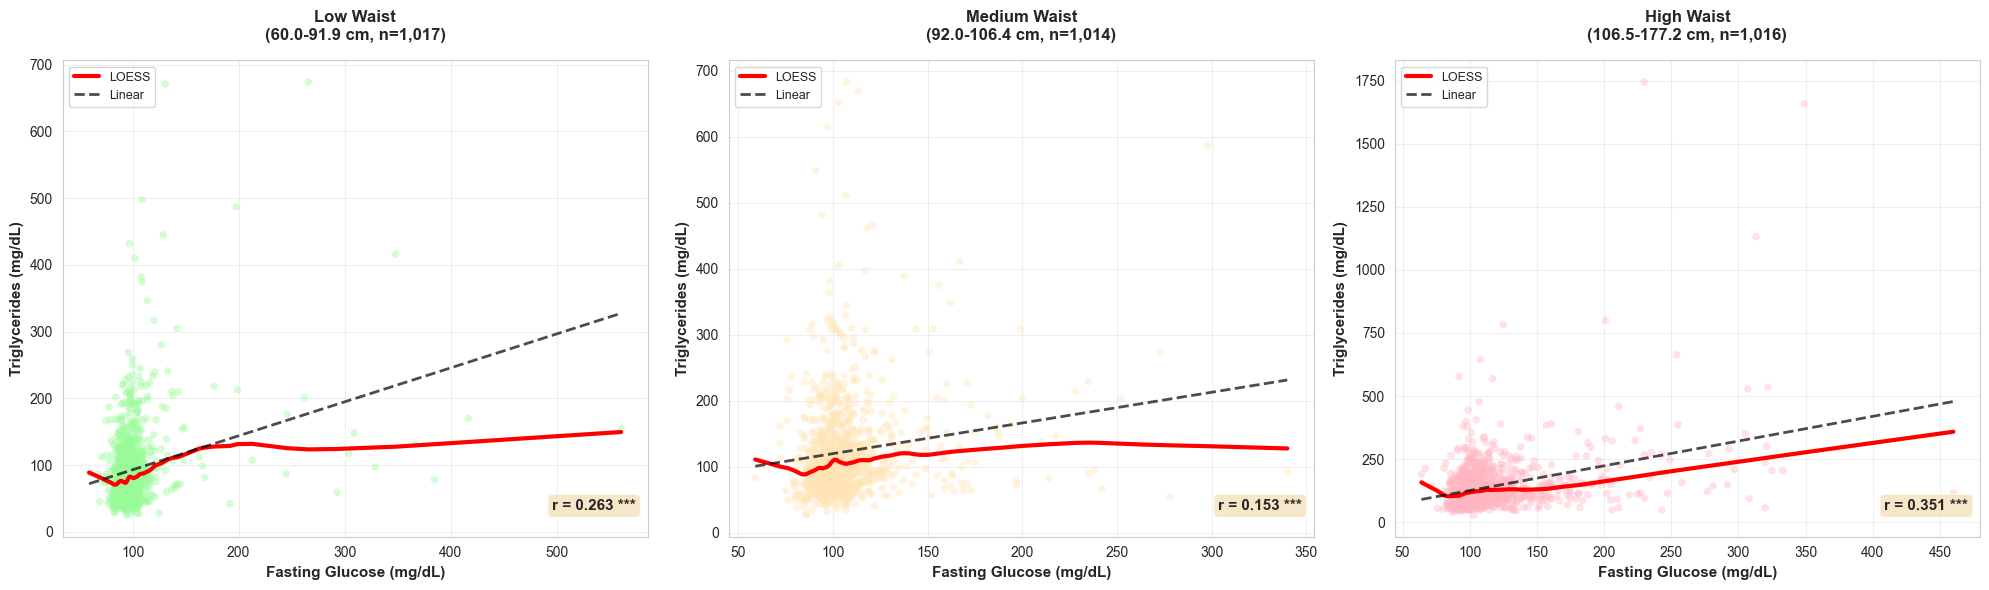


Correlation by Waist Tertile:
Tertile                     r      p-value        n
--------------------------------------------------
Low Waist               0.263   1.5378e-17    1,017
Medium Waist            0.153   9.8766e-07    1,014
High Waist              0.351   7.9323e-31    1,016

Interpretation:
  → Moderate interaction: correlation increases with waist circumference


In [5]:
# Stratify glucose vs triglycerides by waist circumference tertiles
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/stratified_by_waist_tertiles.png'
    else:
        save_path = '../results/figures/stratified_by_waist_tertiles.png'
else:
    save_path = 'results/figures/stratified_by_waist_tertiles.png'

# Create waist tertiles
df_complete['waist_tertile'] = pd.qcut(df_complete['BMXWAIST'], q=3, 
                                        labels=['Low Waist', 'Medium Waist', 'High Waist'])

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

tertile_colors = ['#98FB98', '#FFE4B5', '#FFB6C1']
correlations = []

for idx, tertile in enumerate(['Low Waist', 'Medium Waist', 'High Waist']):
    ax = axes[idx]
    
    subset = df_complete[df_complete['waist_tertile'] == tertile]
    x = subset['LBXGLU'].values
    y = subset['LBXTLG'].values
    
    # Scatterplot
    ax.scatter(x, y, alpha=0.4, s=30, color=tertile_colors[idx], edgecolors='none')
    
    # LOESS smooth
    smoothed = lowess(y, x, frac=0.3)
    ax.plot(smoothed[:, 0], smoothed[:, 1], 'r-', linewidth=3, label='LOESS')
    
    # Linear fit
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_sorted = np.sort(x)
    ax.plot(x_sorted, p(x_sorted), 'k--', linewidth=2, label='Linear', alpha=0.7)
    
    # Labels
    ax.set_xlabel('Fasting Glucose (mg/dL)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Triglycerides (mg/dL)', fontsize=11, fontweight='bold')
    
    # Waist range for this tertile
    waist_min = subset['BMXWAIST'].min()
    waist_max = subset['BMXWAIST'].max()
    ax.set_title(f'{tertile}\n({waist_min:.1f}-{waist_max:.1f} cm, n={len(subset):,})', 
                 fontsize=12, fontweight='bold', pad=15)
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Correlation
    r, p_val = stats.pearsonr(x, y)
    correlations.append((tertile, r, p_val, len(subset)))
    
    sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
    ax.text(0.98, 0.05, f'r = {r:.3f} {sig}', transform=ax.transAxes, 
            ha='right', va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), 
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

# Print correlation comparison
print("\nCorrelation by Waist Tertile:")
print(f"{'Tertile':<20} {'r':>8} {'p-value':>12} {'n':>8}")
print("-" * 50)
for tertile, r, p_val, n in correlations:
    print(f"{tertile:<20} {r:>8.3f} {p_val:>12.4e} {n:>8,}")

# Test if correlations differ
print("\nInterpretation:")
if correlations[2][1] > correlations[0][1] * 1.5:
    print(f"  → Strong interaction: correlation is {correlations[2][1]/correlations[0][1]:.1f}× stronger in high waist group")
elif correlations[2][1] > correlations[0][1] * 1.2:
    print(f"  → Moderate interaction: correlation increases with waist circumference")
else:
    print(f"  → Weak interaction: correlation relatively stable across waist groups")

Saved: ../../results/figures/stratified_comprehensive.png


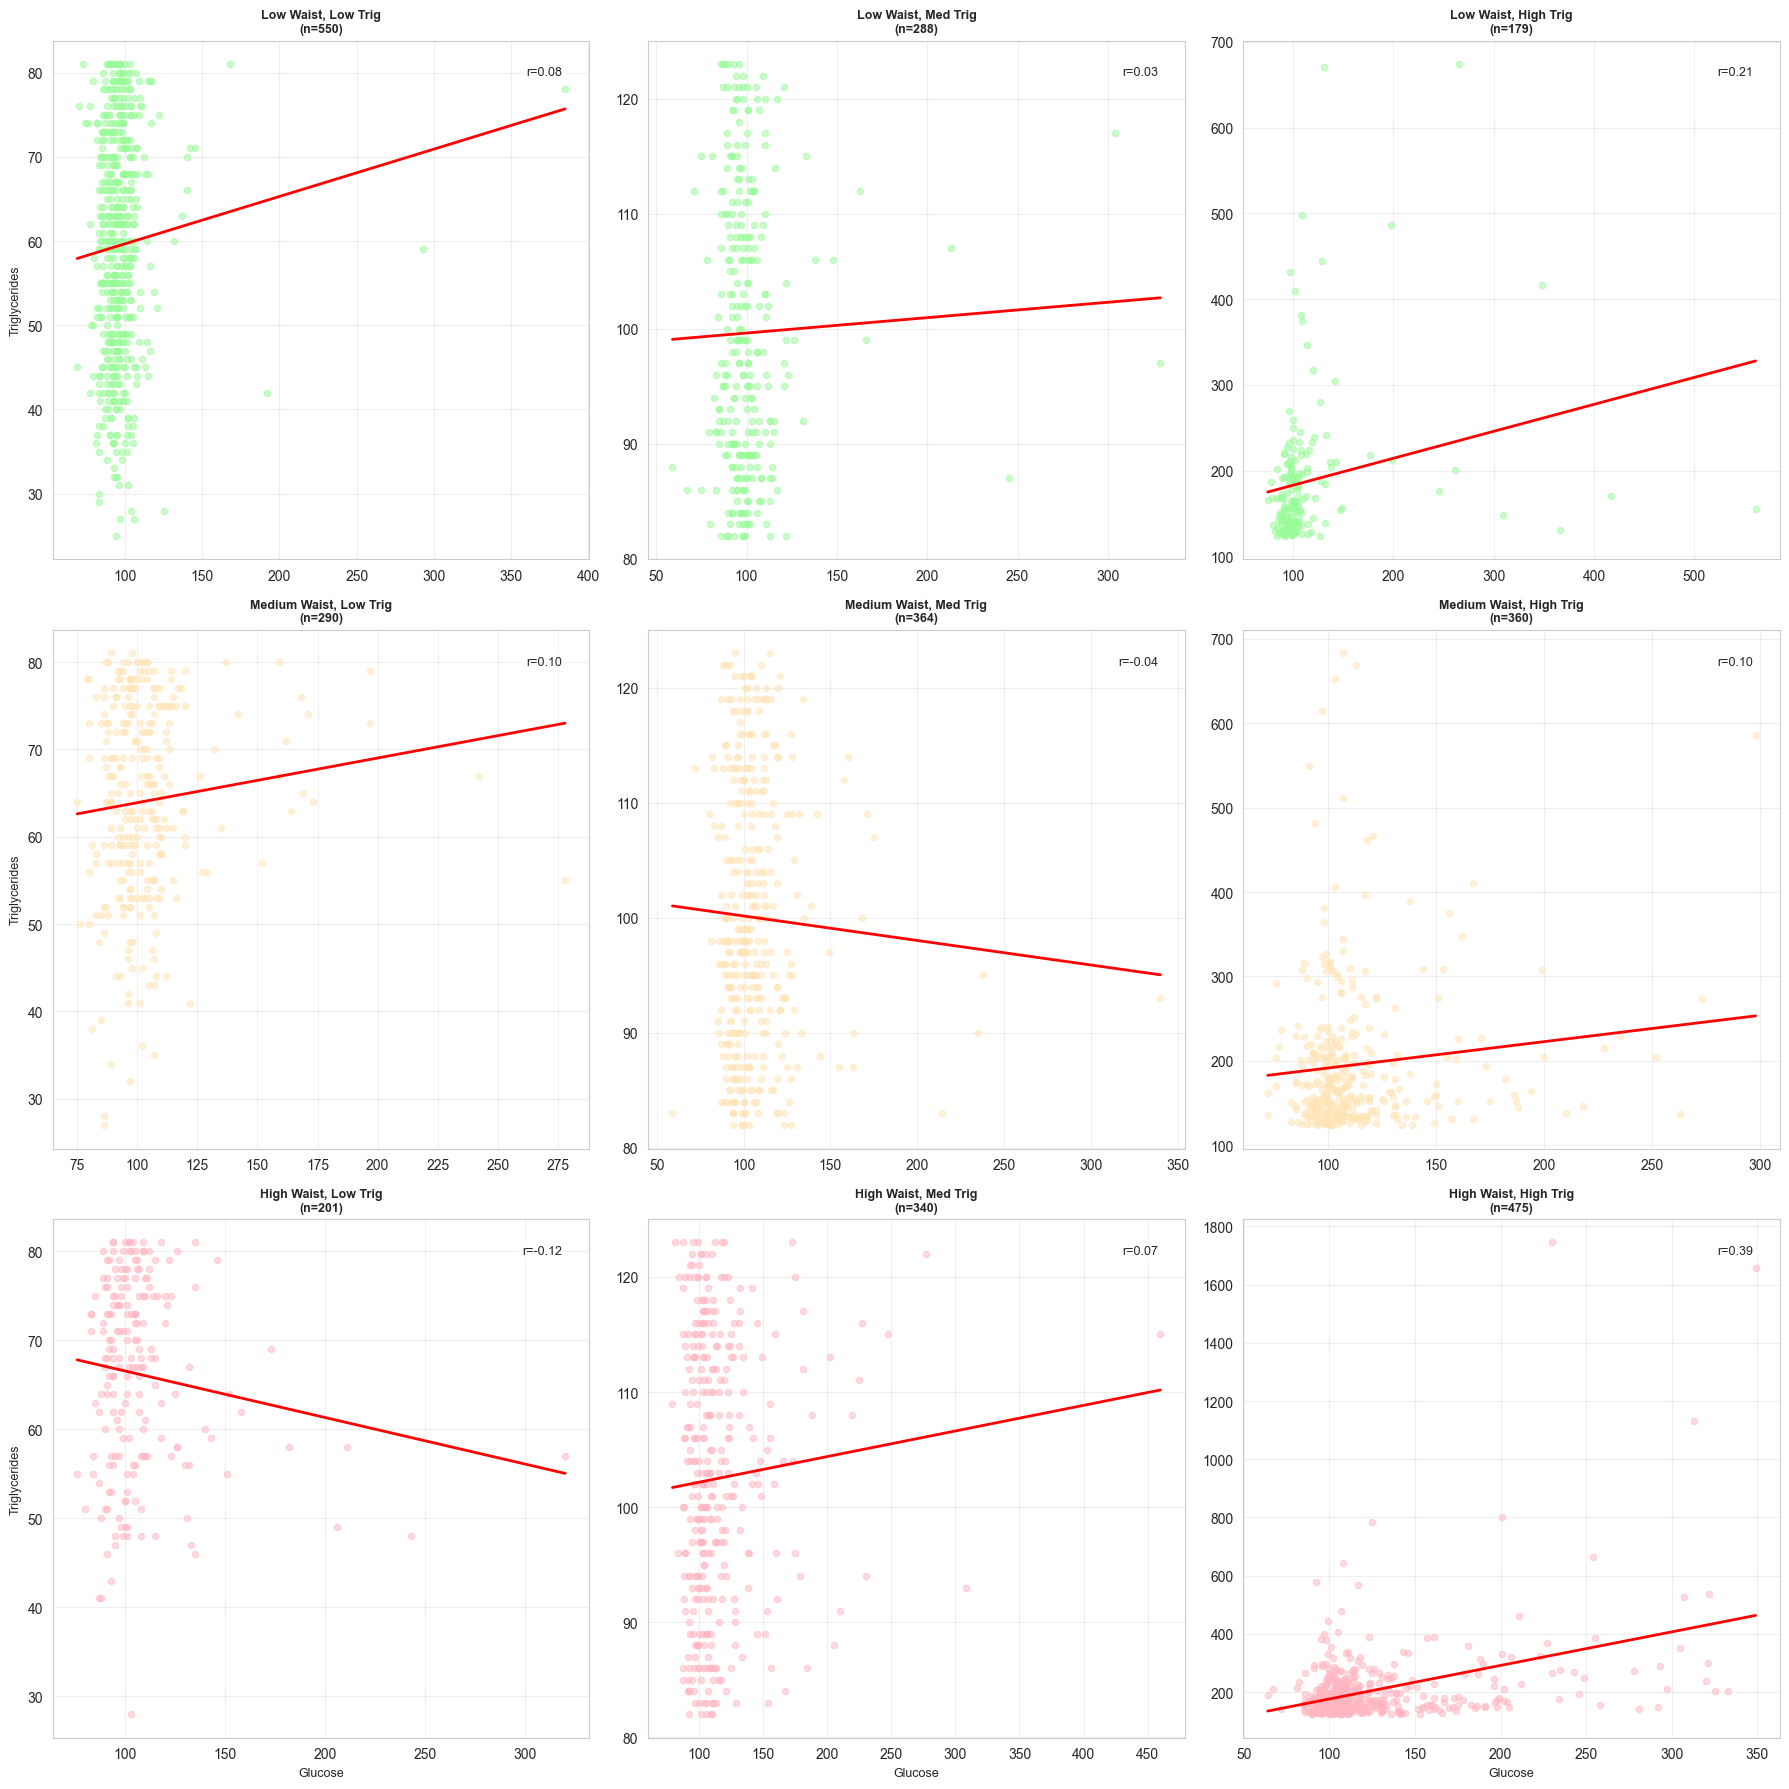

In [6]:
# Create comprehensive stratified view
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/stratified_comprehensive.png'
    else:
        save_path = '../results/figures/stratified_comprehensive.png'
else:
    save_path = 'results/figures/stratified_comprehensive.png'

# Create tertiles for all three variables
df_complete['glucose_tertile'] = pd.qcut(df_complete['LBXGLU'], q=3, 
                                          labels=['Low', 'Med', 'High'])
df_complete['trig_tertile'] = pd.qcut(df_complete['LBXTLG'], q=3, 
                                       labels=['Low', 'Med', 'High'])

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Glucose vs Triglycerides, stratified by Waist
for idx, waist_level in enumerate(['Low Waist', 'Medium Waist', 'High Waist']):
    for jdx, trig_level in enumerate(['Low', 'Med', 'High']):
        ax = axes[idx, jdx]
        
        subset = df_complete[(df_complete['waist_tertile'] == waist_level) & 
                            (df_complete['trig_tertile'] == trig_level)]
        
        if len(subset) > 20:
            x = subset['LBXGLU'].values
            y = subset['LBXTLG'].values
            
            ax.scatter(x, y, alpha=0.5, s=20, color=tertile_colors[idx])
            
            # Linear fit
            if len(subset) > 30:
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                x_sorted = np.sort(x)
                ax.plot(x_sorted, p(x_sorted), 'r-', linewidth=2)
                
                r, _ = stats.pearsonr(x, y)
                ax.text(0.95, 0.95, f'r={r:.2f}', transform=ax.transAxes,
                       ha='right', va='top', fontsize=9,
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        ax.set_title(f'{waist_level}, {trig_level} Trig\n(n={len(subset)})', 
                    fontsize=9, fontweight='bold')
        
        if idx == 2:
            ax.set_xlabel('Glucose', fontsize=9)
        if jdx == 0:
            ax.set_ylabel('Triglycerides', fontsize=9)
        
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

In [7]:
# Test interaction effects using regression
print("INTERACTION EFFECTS - REGRESSION ANALYSIS\n")

# Standardize variables for interaction analysis
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df_complete.copy()
df_scaled[core_vars] = scaler.fit_transform(df_complete[core_vars])

# Model 1: Triglycerides ~ Glucose (no interaction)
X1 = df_scaled[['LBXGLU']].values
y = df_scaled['LBXTLG'].values

X1_with_const = sm.add_constant(X1)
model1 = sm.OLS(y, X1_with_const).fit()

print("Model 1: Triglycerides ~ Glucose")
print(f"  R² = {model1.rsquared:.4f}")
print(f"  Glucose coefficient: {model1.params[1]:.4f} (p={model1.pvalues[1]:.4e})")

# Model 2: Triglycerides ~ Glucose + Waist (additive)
X2 = df_scaled[['LBXGLU', 'BMXWAIST']].values
X2_with_const = sm.add_constant(X2)
model2 = sm.OLS(y, X2_with_const).fit()

print("\nModel 2: Triglycerides ~ Glucose + Waist (additive)")
print(f"  R² = {model2.rsquared:.4f}")
print(f"  Glucose coefficient: {model2.params[1]:.4f} (p={model2.pvalues[1]:.4e})")
print(f"  Waist coefficient: {model2.params[2]:.4f} (p={model2.pvalues[2]:.4e})")

# Model 3: Triglycerides ~ Glucose * Waist (interaction)
df_scaled['glucose_x_waist'] = df_scaled['LBXGLU'] * df_scaled['BMXWAIST']
X3 = df_scaled[['LBXGLU', 'BMXWAIST', 'glucose_x_waist']].values
X3_with_const = sm.add_constant(X3)
model3 = sm.OLS(y, X3_with_const).fit()

print("\nModel 3: Triglycerides ~ Glucose * Waist (interaction)")
print(f"  R² = {model3.rsquared:.4f}")
print(f"  Glucose coefficient: {model3.params[1]:.4f} (p={model3.pvalues[1]:.4e})")
print(f"  Waist coefficient: {model3.params[2]:.4f} (p={model3.pvalues[2]:.4e})")
print(f"  Interaction term: {model3.params[3]:.4f} (p={model3.pvalues[3]:.4e})")

# Compare models
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(f"{'Model':<40} {'R²':>10} {'Δ R²':>10}")
print("-" * 60)
print(f"{'1. Glucose only':<40} {model1.rsquared:>10.4f} {0:>10.4f}")
print(f"{'2. Glucose + Waist (additive)':<40} {model2.rsquared:>10.4f} {model2.rsquared - model1.rsquared:>10.4f}")
print(f"{'3. Glucose × Waist (interaction)':<40} {model3.rsquared:>10.4f} {model3.rsquared - model2.rsquared:>10.4f}")

# Interpretation
print("\nInterpretation:")
if model3.pvalues[3] < 0.001:
    print("  *** Significant interaction effect (p < 0.001)")
    print("  → The glucose-triglyceride relationship DEPENDS on waist circumference")
elif model3.pvalues[3] < 0.05:
    print("  ** Significant interaction effect (p < 0.05)")
    print("  → Modest interaction between glucose and waist")
else:
    print("  No significant interaction effect")
    print("  → Glucose and waist have independent additive effects")

INTERACTION EFFECTS - REGRESSION ANALYSIS

Model 1: Triglycerides ~ Glucose
  R² = 0.0993
  Glucose coefficient: 0.3152 (p=3.0757e-71)

Model 2: Triglycerides ~ Glucose + Waist (additive)
  R² = 0.1215
  Glucose coefficient: 0.2794 (p=2.4018e-55)
  Waist coefficient: 0.1531 (p=3.1423e-18)

Model 3: Triglycerides ~ Glucose * Waist (interaction)
  R² = 0.1219
  Glucose coefficient: 0.2748 (p=5.0095e-51)
  Waist coefficient: 0.1522 (p=5.0487e-18)
  Interaction term: 0.0172 (p=2.5718e-01)

MODEL COMPARISON
Model                                            R²       Δ R²
------------------------------------------------------------
1. Glucose only                              0.0993     0.0000
2. Glucose + Waist (additive)                0.1215     0.0222
3. Glucose × Waist (interaction)             0.1219     0.0004

Interpretation:
  No significant interaction effect
  → Glucose and waist have independent additive effects


In [8]:
# Analyze threshold effects at clinical cutpoints
print("THRESHOLD EFFECTS ANALYSIS\n")

# Create binary threshold groups
df_complete['glucose_threshold'] = (df_complete['LBXGLU'] >= 100).map({True: 'High (≥100)', False: 'Normal (<100)'})
df_complete['trig_threshold'] = (df_complete['LBXTLG'] >= 150).map({True: 'High (≥150)', False: 'Normal (<150)'})
df_complete['waist_threshold'] = df_complete.apply(
    lambda row: 'High' if (row['BMXWAIST'] >= 102) or (row['BMXWAIST'] >= 88) else 'Normal', 
    axis=1
)

# Compare correlations above/below thresholds
print("CORRELATION ANALYSIS BY CLINICAL THRESHOLDS\n")

# 1. Glucose threshold
print("1. GLUCOSE THRESHOLD (100 mg/dL)")
for threshold in ['Normal (<100)', 'High (≥100)']:
    subset = df_complete[df_complete['glucose_threshold'] == threshold]
    r_trig, p_trig = stats.pearsonr(subset['LBXGLU'], subset['LBXTLG'])
    r_waist, p_waist = stats.pearsonr(subset['LBXGLU'], subset['BMXWAIST'])
    
    print(f"\n  {threshold} (n={len(subset):,}):")
    print(f"    Glucose-Triglycerides: r={r_trig:.3f}, p={p_trig:.4e}")
    print(f"    Glucose-Waist: r={r_waist:.3f}, p={p_waist:.4e}")

# 2. Triglycerides threshold
print("\n2. TRIGLYCERIDES THRESHOLD (150 mg/dL)")
for threshold in ['Normal (<150)', 'High (≥150)']:
    subset = df_complete[df_complete['trig_threshold'] == threshold]
    r_gluc, p_gluc = stats.pearsonr(subset['LBXTLG'], subset['LBXGLU'])
    r_waist, p_waist = stats.pearsonr(subset['LBXTLG'], subset['BMXWAIST'])
    
    print(f"\n  {threshold} (n={len(subset):,}):")
    print(f"    Triglycerides-Glucose: r={r_gluc:.3f}, p={p_gluc:.4e}")
    print(f"    Triglycerides-Waist: r={r_waist:.3f}, p={p_waist:.4e}")

# 3. Compare slopes above/below thresholds
print("\n3. SLOPE COMPARISON (Linear Regression)")

# Glucose vs Triglycerides
subset_low = df_complete[df_complete['glucose_threshold'] == 'Normal (<100)']
subset_high = df_complete[df_complete['glucose_threshold'] == 'High (≥100)']

slope_low_gt = np.polyfit(subset_low['LBXGLU'], subset_low['LBXTLG'], 1)[0]
slope_high_gt = np.polyfit(subset_high['LBXGLU'], subset_high['LBXTLG'], 1)[0]

print(f"\n  Glucose vs Triglycerides:")
print(f"    Slope below 100 mg/dL: {slope_low_gt:.3f}")
print(f"    Slope above 100 mg/dL: {slope_high_gt:.3f}")
print(f"    Ratio (high/low): {slope_high_gt/slope_low_gt:.2f}×")

if slope_high_gt > slope_low_gt * 1.5:
    print(f"    → Strong threshold effect: relationship {slope_high_gt/slope_low_gt:.1f}× steeper above threshold")
elif slope_high_gt > slope_low_gt * 1.2:
    print(f"    → Moderate threshold effect detected")
else:
    print(f"    → No substantial threshold effect")

THRESHOLD EFFECTS ANALYSIS

CORRELATION ANALYSIS BY CLINICAL THRESHOLDS

1. GLUCOSE THRESHOLD (100 mg/dL)

  Normal (<100) (n=1,370):
    Glucose-Triglycerides: r=0.103, p=1.3029e-04
    Glucose-Waist: r=0.126, p=2.8211e-06

  High (≥100) (n=1,677):
    Glucose-Triglycerides: r=0.287, p=3.5100e-33
    Glucose-Waist: r=0.129, p=1.0801e-07

2. TRIGLYCERIDES THRESHOLD (150 mg/dL)

  Normal (<150) (n=2,376):
    Triglycerides-Glucose: r=0.174, p=1.4086e-17
    Triglycerides-Waist: r=0.322, p=1.3440e-58

  High (≥150) (n=671):
    Triglycerides-Glucose: r=0.299, p=2.5968e-15
    Triglycerides-Waist: r=0.018, p=6.4259e-01

3. SLOPE COMPARISON (Linear Regression)

  Glucose vs Triglycerides:
    Slope below 100 mg/dL: 1.094
    Slope above 100 mg/dL: 0.742
    Ratio (high/low): 0.68×
    → No substantial threshold effect


Saved: ../../results/figures/threshold_effects.png


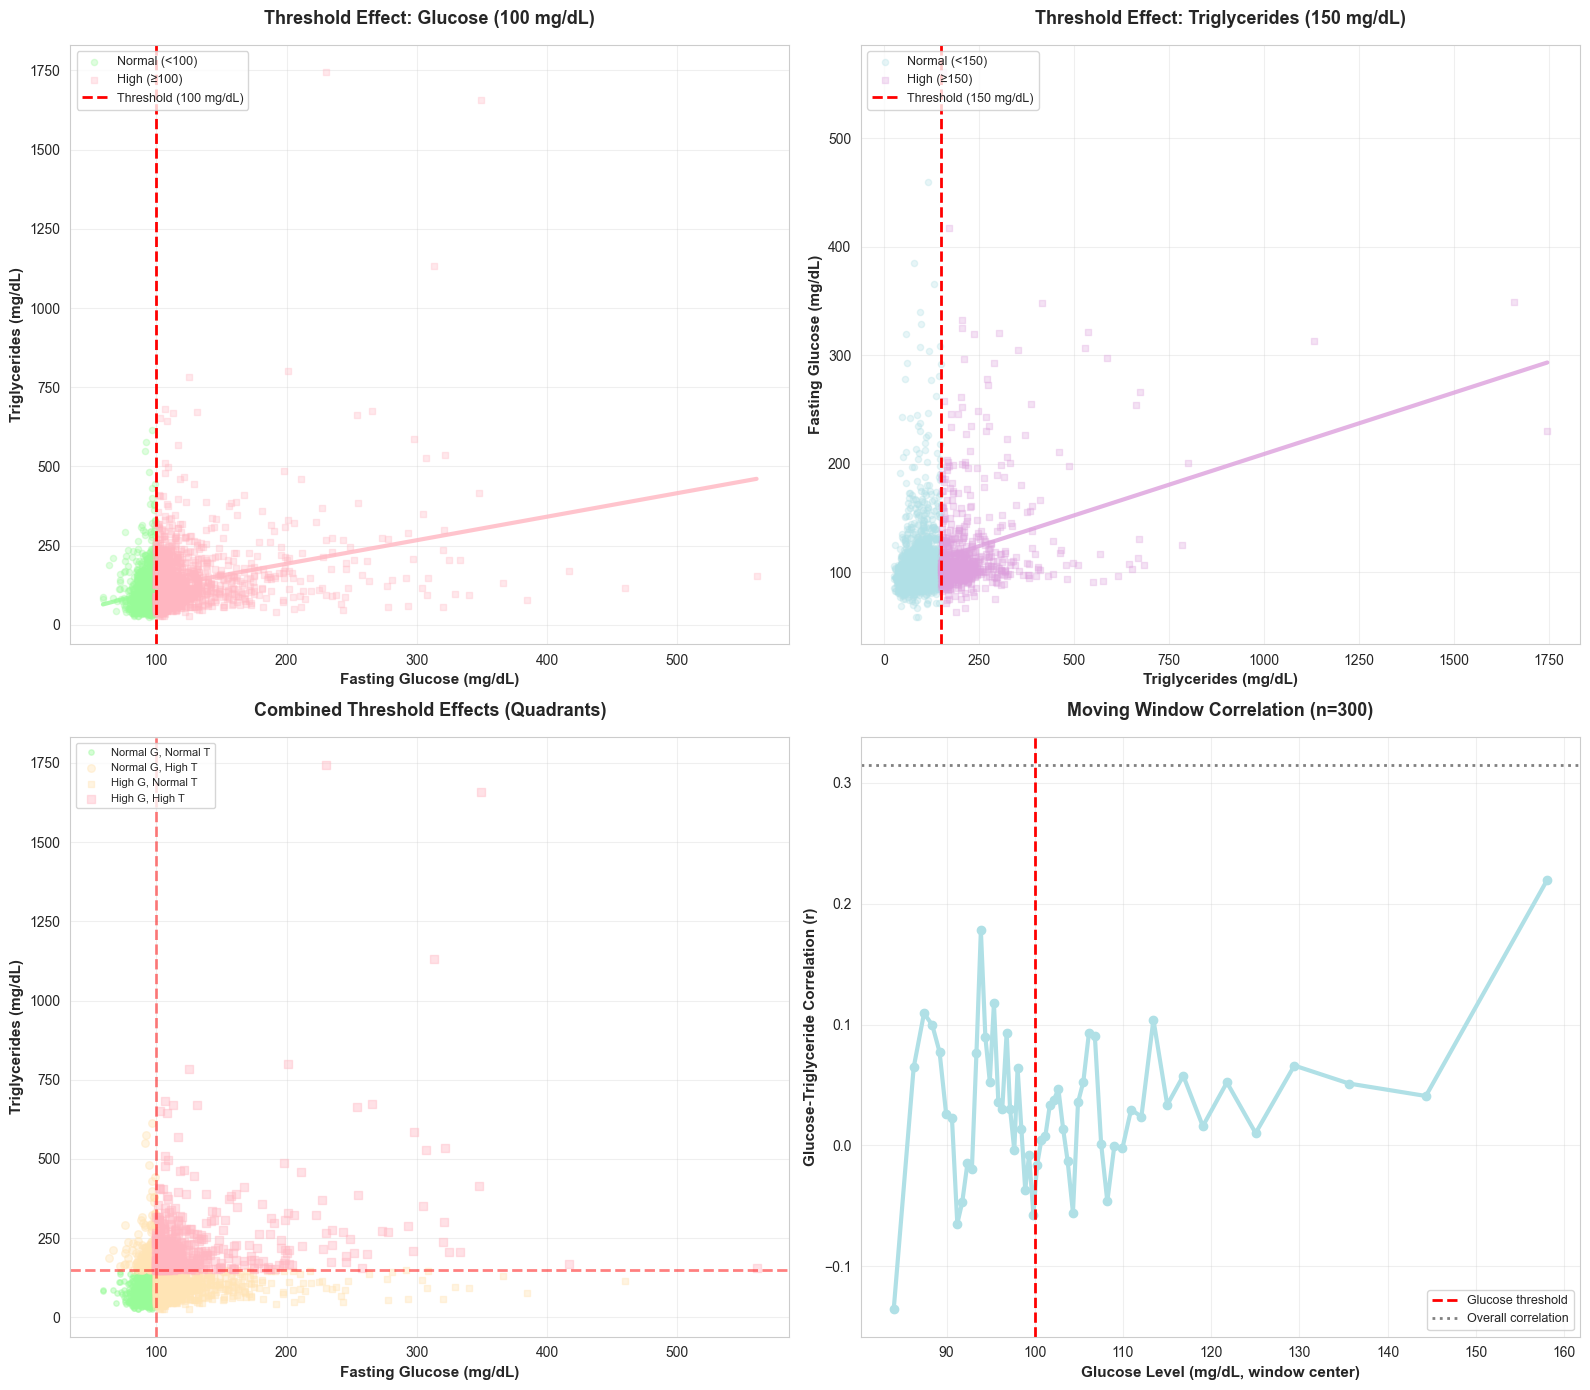

In [9]:
# Visualize threshold effects
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/threshold_effects.png'
    else:
        save_path = '../results/figures/threshold_effects.png'
else:
    save_path = 'results/figures/threshold_effects.png'

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Glucose threshold effect (Glucose vs Triglycerides)
ax1 = axes[0, 0]
for threshold, color, marker in [('Normal (<100)', '#98FB98', 'o'), ('High (≥100)', '#FFB6C1', 's')]:
    subset = df_complete[df_complete['glucose_threshold'] == threshold]
    ax1.scatter(subset['LBXGLU'], subset['LBXTLG'], alpha=0.3, s=20, 
               color=color, marker=marker, label=threshold)
    
    # Fit line for each group
    z = np.polyfit(subset['LBXGLU'], subset['LBXTLG'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(subset['LBXGLU'].min(), subset['LBXGLU'].max(), 100)
    ax1.plot(x_range, p(x_range), linewidth=3, color=color, alpha=0.8)

ax1.axvline(x=100, color='red', linestyle='--', linewidth=2, label='Threshold (100 mg/dL)')
ax1.set_xlabel('Fasting Glucose (mg/dL)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Triglycerides (mg/dL)', fontsize=11, fontweight='bold')
ax1.set_title('Threshold Effect: Glucose (100 mg/dL)', fontsize=13, fontweight='bold', pad=15)
ax1.legend(fontsize=9, loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Triglycerides threshold effect (Triglycerides vs Glucose)
ax2 = axes[0, 1]
for threshold, color, marker in [('Normal (<150)', '#B0E0E6', 'o'), ('High (≥150)', '#DDA0DD', 's')]:
    subset = df_complete[df_complete['trig_threshold'] == threshold]
    ax2.scatter(subset['LBXTLG'], subset['LBXGLU'], alpha=0.3, s=20, 
               color=color, marker=marker, label=threshold)
    
    z = np.polyfit(subset['LBXTLG'], subset['LBXGLU'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(subset['LBXTLG'].min(), subset['LBXTLG'].max(), 100)
    ax2.plot(x_range, p(x_range), linewidth=3, color=color, alpha=0.8)

ax2.axvline(x=150, color='red', linestyle='--', linewidth=2, label='Threshold (150 mg/dL)')
ax2.set_xlabel('Triglycerides (mg/dL)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Fasting Glucose (mg/dL)', fontsize=11, fontweight='bold')
ax2.set_title('Threshold Effect: Triglycerides (150 mg/dL)', fontsize=13, fontweight='bold', pad=15)
ax2.legend(fontsize=9, loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Combined thresholds (2x2 grid)
ax3 = axes[1, 0]
for g_thresh in ['Normal (<100)', 'High (≥100)']:
    for t_thresh in ['Normal (<150)', 'High (≥150)']:
        subset = df_complete[(df_complete['glucose_threshold'] == g_thresh) & 
                            (df_complete['trig_threshold'] == t_thresh)]
        
        color = '#98FB98' if (g_thresh == 'Normal (<100)' and t_thresh == 'Normal (<150)') else \
                '#FFB6C1' if (g_thresh == 'High (≥100)' and t_thresh == 'High (≥150)') else \
                '#FFE4B5'
        
        marker = 'o' if g_thresh == 'Normal (<100)' else 's'
        size = 30 if t_thresh == 'High (≥150)' else 15
        
        ax3.scatter(subset['LBXGLU'], subset['LBXTLG'], alpha=0.4, s=size,
                   color=color, marker=marker, 
                   label=f'{g_thresh.split()[0]} G, {t_thresh.split()[0]} T')

ax3.axvline(x=100, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax3.axhline(y=150, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax3.set_xlabel('Fasting Glucose (mg/dL)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Triglycerides (mg/dL)', fontsize=11, fontweight='bold')
ax3.set_title('Combined Threshold Effects (Quadrants)', fontsize=13, fontweight='bold', pad=15)
ax3.legend(fontsize=8, loc='upper left')
ax3.grid(True, alpha=0.3)

# Plot 4: Moving correlation (windowed)
ax4 = axes[1, 1]

# Sort by glucose and calculate moving correlation
df_sorted = df_complete.sort_values('LBXGLU').reset_index(drop=True)
window_size = 300
correlations = []
glucose_centers = []

for i in range(0, len(df_sorted) - window_size, 50):
    window = df_sorted.iloc[i:i+window_size]
    r, _ = stats.pearsonr(window['LBXGLU'], window['LBXTLG'])
    correlations.append(r)
    glucose_centers.append(window['LBXGLU'].mean())

ax4.plot(glucose_centers, correlations, linewidth=3, color='#B0E0E6', marker='o', markersize=6)
ax4.axvline(x=100, color='red', linestyle='--', linewidth=2, label='Glucose threshold')
ax4.axhline(y=corr_matrix.loc['LBXGLU', 'LBXTLG'], color='gray', linestyle=':', 
           linewidth=2, label='Overall correlation')
ax4.set_xlabel('Glucose Level (mg/dL, window center)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Glucose-Triglyceride Correlation (r)', fontsize=11, fontweight='bold')
ax4.set_title('Moving Window Correlation (n=300)', fontsize=13, fontweight='bold', pad=15)
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

In [10]:
# Segmented regression to detect breakpoints
print("SEGMENTED REGRESSION ANALYSIS\n")

# Function to fit segmented regression
def fit_segmented_regression(x, y, breakpoint):
    """Fit piecewise linear regression with given breakpoint"""
    # Create indicator for above/below breakpoint
    indicator = (x > breakpoint).astype(int)
    interaction = (x - breakpoint) * indicator
    
    # Fit model: y ~ x + indicator + interaction
    X = np.column_stack([x, indicator, interaction])
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()
    
    return model

# Test breakpoint at clinical threshold (100 mg/dL for glucose)
x = df_complete['LBXGLU'].values
y = df_complete['LBXTLG'].values

# Fit linear model (no breakpoint)
linear_model = sm.OLS(y, sm.add_constant(x)).fit()

# Fit segmented model (breakpoint at 100)
segmented_model = fit_segmented_regression(x, y, 100)

print("Linear Model (no breakpoint):")
print(f"  R² = {linear_model.rsquared:.4f}")
print(f"  AIC = {linear_model.aic:.2f}")

print("\nSegmented Model (breakpoint at 100 mg/dL):")
print(f"  R² = {segmented_model.rsquared:.4f}")
print(f"  AIC = {segmented_model.aic:.2f}")
print(f"  Improvement in R²: {segmented_model.rsquared - linear_model.rsquared:.4f}")

# Test if segmented model is significantly better
if segmented_model.rsquared > linear_model.rsquared:
    # F-test for nested models
    f_stat = ((segmented_model.rsquared - linear_model.rsquared) * (len(x) - 4)) / \
             ((1 - segmented_model.rsquared) * 2)
    p_val = 1 - stats.f.cdf(f_stat, 2, len(x) - 4)
    
    print(f"\nF-test for model improvement:")
    print(f"  F = {f_stat:.3f}")
    print(f"  p-value = {p_val:.4e}")
    
    if p_val < 0.001:
        print("  *** Segmented model is significantly better (p < 0.001)")
        print("  → Strong evidence for threshold/breakpoint effect at 100 mg/dL")
    elif p_val < 0.05:
        print("  ** Segmented model is better (p < 0.05)")
    else:
        print("  No significant improvement from segmented model")

# Calculate slopes before and after breakpoint
below_100 = df_complete[df_complete['LBXGLU'] < 100]
above_100 = df_complete[df_complete['LBXGLU'] >= 100]

slope_below = np.polyfit(below_100['LBXGLU'], below_100['LBXTLG'], 1)[0]
slope_above = np.polyfit(above_100['LBXGLU'], above_100['LBXTLG'], 1)[0]

print(f"\nSlope comparison:")
print(f"  Below 100 mg/dL: {slope_below:.3f} mg/dL per mg/dL glucose")
print(f"  Above 100 mg/dL: {slope_above:.3f} mg/dL per mg/dL glucose")
print(f"  Ratio: {slope_above/slope_below:.2f}×")

SEGMENTED REGRESSION ANALYSIS

Linear Model (no breakpoint):
  R² = 0.0993
  AIC = 35584.37

Segmented Model (breakpoint at 100 mg/dL):
  R² = 0.1030
  AIC = 35575.82
  Improvement in R²: 0.0037

F-test for model improvement:
  F = 6.280
  p-value = 1.8972e-03
  ** Segmented model is better (p < 0.05)

Slope comparison:
  Below 100 mg/dL: 1.094 mg/dL per mg/dL glucose
  Above 100 mg/dL: 0.742 mg/dL per mg/dL glucose
  Ratio: 0.68×


Saved: ../../results/figures/interaction_3d_surface.png


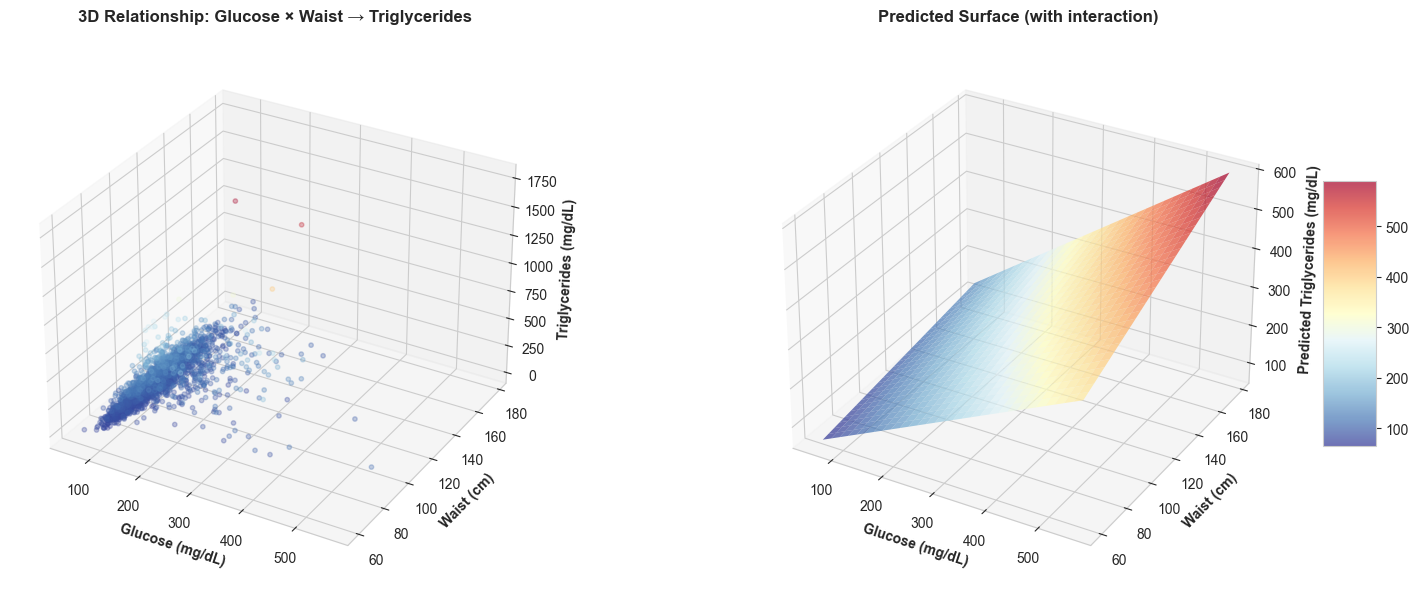

In [11]:
# Create 3D surface plot showing interaction
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D

current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/interaction_3d_surface.png'
    else:
        save_path = '../results/figures/interaction_3d_surface.png'
else:
    save_path = 'results/figures/interaction_3d_surface.png'

fig = plt.figure(figsize=(16, 6))

# Left plot: 3D scatter
ax1 = fig.add_subplot(121, projection='3d')

x = df_complete['LBXGLU'].values
y = df_complete['BMXWAIST'].values
z = df_complete['LBXTLG'].values

# Color by triglycerides level
colors = plt.cm.RdYlBu_r(z / z.max())

ax1.scatter(x, y, z, c=colors, marker='o', s=10, alpha=0.3)

ax1.set_xlabel('Glucose (mg/dL)', fontsize=10, fontweight='bold')
ax1.set_ylabel('Waist (cm)', fontsize=10, fontweight='bold')
ax1.set_zlabel('Triglycerides (mg/dL)', fontsize=10, fontweight='bold')
ax1.set_title('3D Relationship: Glucose × Waist → Triglycerides', 
              fontsize=12, fontweight='bold', pad=20)

# Right plot: Predicted surface from regression
ax2 = fig.add_subplot(122, projection='3d')

# Create grid
glucose_range = np.linspace(x.min(), x.max(), 30)
waist_range = np.linspace(y.min(), y.max(), 30)
glucose_grid, waist_grid = np.meshgrid(glucose_range, waist_range)

# Standardize for prediction
glucose_std = (glucose_grid - df_complete['LBXGLU'].mean()) / df_complete['LBXGLU'].std()
waist_std = (waist_grid - df_complete['BMXWAIST'].mean()) / df_complete['BMXWAIST'].std()
interaction_grid = glucose_std * waist_std

# Predict using model3
X_pred = np.column_stack([
    np.ones(glucose_std.flatten().shape),
    glucose_std.flatten(),
    waist_std.flatten(),
    interaction_grid.flatten()
])

trig_pred = model3.predict(X_pred)
trig_pred = trig_pred * df_complete['LBXTLG'].std() + df_complete['LBXTLG'].mean()
trig_pred_grid = trig_pred.reshape(glucose_grid.shape)

# Plot surface
surf = ax2.plot_surface(glucose_grid, waist_grid, trig_pred_grid, 
                        cmap='RdYlBu_r', alpha=0.7, edgecolor='none')

ax2.set_xlabel('Glucose (mg/dL)', fontsize=10, fontweight='bold')
ax2.set_ylabel('Waist (cm)', fontsize=10, fontweight='bold')
ax2.set_zlabel('Predicted Triglycerides (mg/dL)', fontsize=10, fontweight='bold')
ax2.set_title('Predicted Surface (with interaction)', fontsize=12, fontweight='bold', pad=20)

fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

Saved: ../../results/figures/interaction_faceted.png


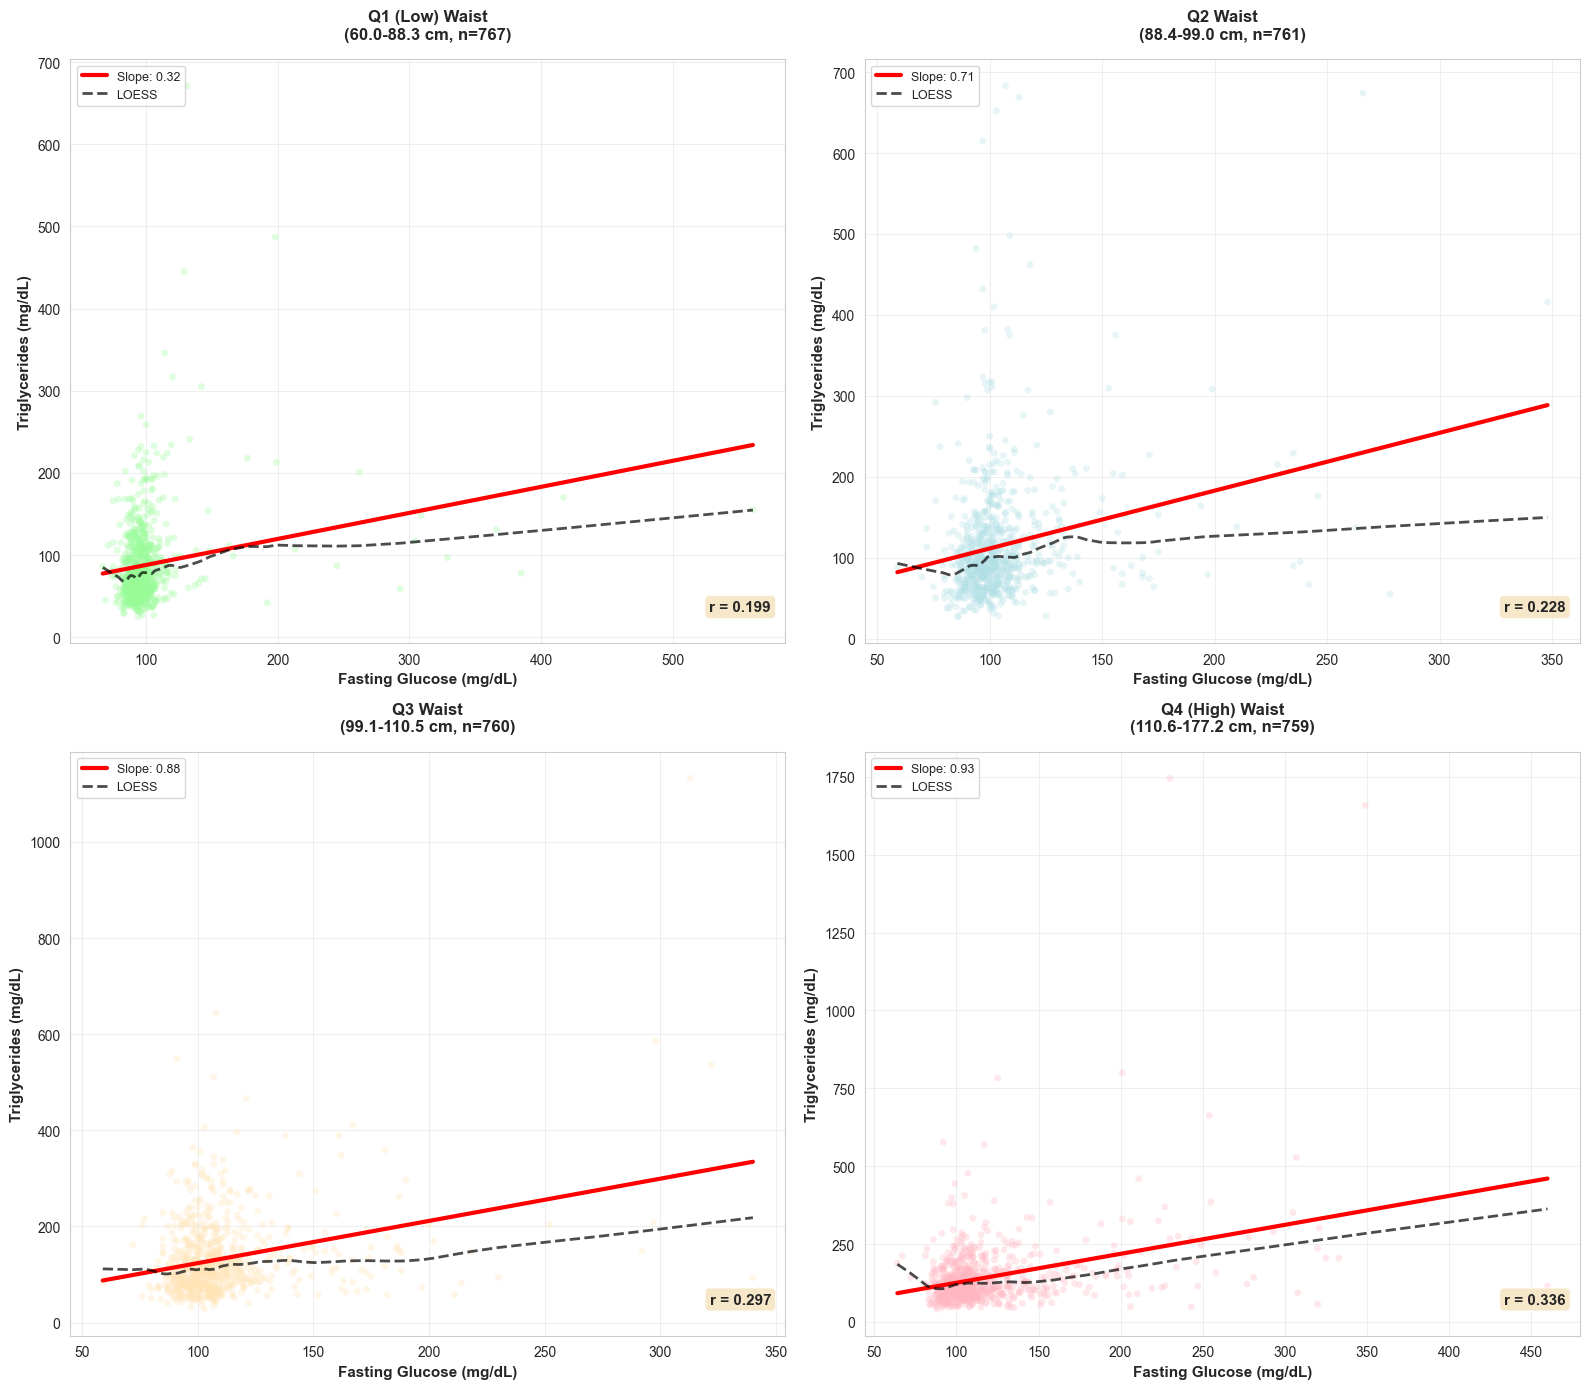


Slope Trend Across Waist Quartiles:
Quartile             Slope     Change
-----------------------------------
Q1 (Low)             0.317       0.0%
Q2                   0.715     125.6%
Q3                   0.879     177.4%
Q4 (High)            0.930     193.5%

Overall slope increase from Q1 to Q4: 193.5%


In [12]:
# Create faceted plot showing interaction more clearly
from pathlib import Path
current = Path.cwd()

if 'notebooks' in str(current):
    if 'explore_data' in str(current):
        save_path = '../../results/figures/interaction_faceted.png'
    else:
        save_path = '../results/figures/interaction_faceted.png'
else:
    save_path = 'results/figures/interaction_faceted.png'

# Create quartiles for waist
df_complete['waist_quartile'] = pd.qcut(df_complete['BMXWAIST'], q=4, 
                                        labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

quartile_colors = ['#98FB98', '#B0E0E6', '#FFE4B5', '#FFB6C1']
slopes = []

for idx, quartile in enumerate(['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)']):
    ax = axes[idx]
    
    subset = df_complete[df_complete['waist_quartile'] == quartile]
    x = subset['LBXGLU'].values
    y = subset['LBXTLG'].values
    
    # Scatterplot
    ax.scatter(x, y, alpha=0.3, s=25, color=quartile_colors[idx], edgecolors='none')
    
    # Linear fit
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_sorted = np.sort(x)
    ax.plot(x_sorted, p(x_sorted), 'r-', linewidth=3, label=f'Slope: {z[0]:.2f}')
    slopes.append(z[0])
    
    # LOESS for comparison
    smoothed = lowess(y, x, frac=0.3)
    ax.plot(smoothed[:, 0], smoothed[:, 1], 'k--', linewidth=2, alpha=0.7, label='LOESS')
    
    # Waist range
    waist_min = subset['BMXWAIST'].min()
    waist_max = subset['BMXWAIST'].max()
    
    ax.set_xlabel('Fasting Glucose (mg/dL)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Triglycerides (mg/dL)', fontsize=11, fontweight='bold')
    ax.set_title(f'{quartile} Waist\n({waist_min:.1f}-{waist_max:.1f} cm, n={len(subset):,})', 
                 fontsize=12, fontweight='bold', pad=15)
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Correlation
    r, p_val = stats.pearsonr(x, y)
    ax.text(0.98, 0.05, f'r = {r:.3f}', transform=ax.transAxes, 
            ha='right', va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), 
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

# Slope trend
print("\nSlope Trend Across Waist Quartiles:")
print(f"{'Quartile':<15} {'Slope':>10} {'Change':>10}")
print("-" * 35)
for i, (q, slope) in enumerate(zip(['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'], slopes)):
    change = (slope - slopes[0]) / slopes[0] * 100 if i > 0 else 0
    print(f"{q:<15} {slope:>10.3f} {change:>9.1f}%")

print(f"\nOverall slope increase from Q1 to Q4: {(slopes[3]-slopes[0])/slopes[0]*100:.1f}%")